In [32]:
import os
import pandas as pd
import matplotlib as plt
import numpy as np

import tiktoken
import openai
from openai.embeddings_utils import distances_from_embeddings


In [19]:
def remove_newlines(serie):
    serie = serie.replace('\n', ' ')
    serie = serie.replace('\\n', ' ')
    serie = serie.replace('  ', ' ')
    serie = serie.replace('  ', ' ')
    return serie

In [20]:
# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
directory = "./text"
for file in os.listdir(directory):

    # Open the file and read the text
    with open(directory + "/" + file, "r", encoding="UTF-8") as f:
        text = f.read()
        text = remove_newlines(text)

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[0:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed_kb.csv')
df.head()

,fname,text
0,CryptoGuides ProjectDetails,CryptoGuides ProjectDetails. Crypto Guides Our...
1,eAuto ProjectDetails,eAuto ProjectDetails. eAuto Problem Statement ...
2,passed messages,"passed messages. ﻿{""prompt"":""Good evening sir,..."
3,SIP copywriting,SIP copywriting. Registration <Below Register>...
4,WebHelpers ProjectDetails,WebHelpers ProjectDetails. WebHelpers - Projec...


<Axes: >

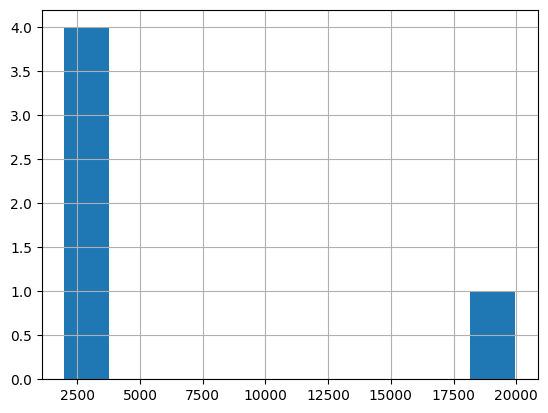

In [21]:
# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed_kb.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [22]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<Axes: >

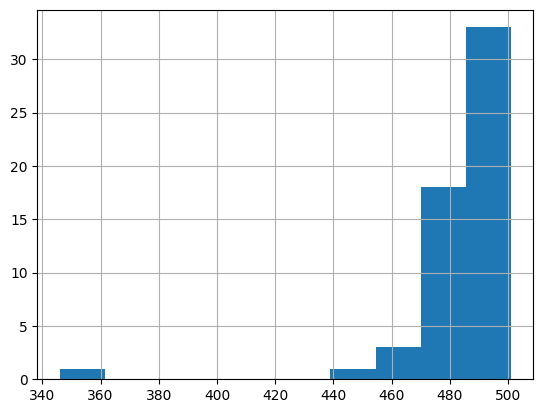

In [23]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist() 

In [27]:
df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])

df.to_csv('embeddings.csv')
df.head()

,text,n_tokens,embeddings
0,CryptoGuides ProjectDetails. Crypto Guides Our...,346,"[-0.015424718149006367, 0.0018016576068475842,..."
1,"In any case, we need you to find a data source...",486,"[-0.003910231404006481, -0.002380660967901349,..."
2,Can you create a data pipeline that will take ...,501,"[-0.011317589320242405, -0.004701944068074226,..."
3,Please create a data pipeline for both Etereum...,471,"[-0.014772243797779083, 0.007331409957259893, ..."
4,eAuto ProjectDetails. eAuto Problem Statement ...,467,"[-0.00368924206122756, -0.012690437957644463, ..."


In [33]:
df=pd.read_csv('embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,CryptoGuides ProjectDetails. Crypto Guides Our...,346,"[-0.015424718149006367, 0.0018016576068475842,..."
1,"In any case, we need you to find a data source...",486,"[-0.003910231404006481, -0.002380660967901349,..."
2,Can you create a data pipeline that will take ...,501,"[-0.011317589320242405, -0.004701944068074226,..."
3,Please create a data pipeline for both Etereum...,471,"[-0.014772243797779083, 0.007331409957259893, ..."
4,eAuto ProjectDetails. eAuto Problem Statement ...,467,"[-0.00368924206122756, -0.012690437957644463, ..."


In [34]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

In [76]:
def answer_question(
    df,
    question,
    #model="gpt-3.5-turbo",
    model ="text-davinci-003",
    max_len=2000,
    size="ada",
    debug=False,
    max_tokens=750,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    # try: 
    #     #create a chatcompletion using the question and context
    #     response = openai.ChatCompletion.create(
    #     temperature=0,
    #     max_tokens=max_tokens,
    #     top_p=1,
    #     frequency_penalty=0,
    #     presence_penalty=0,
    #     stop=stop_sequence,
    #     model=model,
        
    #     messages=[
    #         {"role": "system", "content": f"You are a helpful assistant to interns working for an AI consulting company. When replying to the interns, the first thing you should do is base your answers on the context given below. \n\nContext: {context}"},
    #         {"role": "user", "content": question}
    #     ]
    #     )
    #     return response["choices"][1]["content"].strip()
    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, do your best to answer. \n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()

    except Exception as e:
        print(e)
        return ""

In [80]:
response = answer_question(df, question="What do I need to do for task 1 of eAuto?")
print(response)

It is not possible to answer this question based on the context provided.


In [72]:
question = input('What can I do for you? \n>')
response = answer_question(df, question)
print("\n"+response)

while question != 'exit':
    question = input('Is there anything else? \n>')
    response = answer_question(df, question)
    print("\n"+response)
    
print("Goodbye")

This is a chat model and not supported in the v1/completions endpoint. Did you mean to use v1/chat/completions?


This is a chat model and not supported in the v1/completions endpoint. Did you mean to use v1/chat/completions?


Goodbye
